# Train a model with real estate data using XGBoost algorithm

## Import Libraries and Load Dataset

In [1]:
# Install necessary libraries
# !pip install xgboost
# !pip install sagemaker


# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from xgboost import plot_importance


%matplotlib inline

## Modeling

In [2]:
df_final=pd.read_csv('data/final_dataset_1.csv')

In [39]:
# Define X and y

target_feature = 'actual_worth'

# Log-transform the target
y = np.log1p(df_final[target_feature])  # log1p for log(1 + x) to safely handle 0

# Prepare features
X = df_final.drop([target_feature], axis=1)

# Log-transform the 'area' feature
if 'procedure_area' in X.columns:
    X['procedure_area'] = np.log1p(X['procedure_area'])
else:
    raise KeyError("'procedure_area' feature not found in the dataset")


### Train the model

In [40]:
# Transform data of object type to categories for XGBoost Regressor
categorical_cols = X.select_dtypes(include=['object']).columns
X[categorical_cols]=X[categorical_cols].astype("category")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687236 entries, 0 to 687235
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   trans_group_en        687236 non-null  category
 1   procedure_name_en     687236 non-null  category
 2   property_sub_type_en  687236 non-null  category
 3   property_usage_en     687236 non-null  category
 4   reg_type_en           687236 non-null  category
 5   area_name_en          687236 non-null  category
 6   master_project_en     600078 non-null  category
 7   nearest_landmark_en   598105 non-null  category
 8   nearest_metro_en      542808 non-null  category
 9   nearest_mall_en       541840 non-null  category
 10  rooms_en              685826 non-null  category
 11  has_parking           687236 non-null  int64   
 12  procedure_area        687236 non-null  float64 
 13  year                  687236 non-null  int64   
 14  month                 687236 non-nul

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 50% for testing and 50% for validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) 

In [42]:
model = XGBRegressor(objective='reg:squarederror', 
                     learning_rate=0.1, 
                     max_depth=30, 
                     n_estimators=100, 
                     verbosity = 2,
                     eval_metric='rmse',
                     early_stopping_rounds=10,
                     enable_categorical=True,
                     reg_alpha=1,
                     reg_lambda=10
                     )

model.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_val,y_val)])

# Evaluate the model
score = model.score(X_test, y_test)
print("Model Score:", score)

[0]	validation_0-rmse:0.73459	validation_1-rmse:0.73332
[1]	validation_0-rmse:0.67166	validation_1-rmse:0.67138
[2]	validation_0-rmse:0.61551	validation_1-rmse:0.61618
[3]	validation_0-rmse:0.56525	validation_1-rmse:0.56699
[4]	validation_0-rmse:0.52057	validation_1-rmse:0.52333
[5]	validation_0-rmse:0.48069	validation_1-rmse:0.48462
[6]	validation_0-rmse:0.44527	validation_1-rmse:0.45035
[7]	validation_0-rmse:0.41376	validation_1-rmse:0.42007
[8]	validation_0-rmse:0.38586	validation_1-rmse:0.39340
[9]	validation_0-rmse:0.36112	validation_1-rmse:0.36998
[10]	validation_0-rmse:0.33922	validation_1-rmse:0.34947
[11]	validation_0-rmse:0.31975	validation_1-rmse:0.33146
[12]	validation_0-rmse:0.30256	validation_1-rmse:0.31577
[13]	validation_0-rmse:0.28731	validation_1-rmse:0.30211
[14]	validation_0-rmse:0.27384	validation_1-rmse:0.29024
[15]	validation_0-rmse:0.26189	validation_1-rmse:0.28002
[16]	validation_0-rmse:0.25130	validation_1-rmse:0.27106
[17]	validation_0-rmse:0.24184	validation

In [7]:
eval_result = model.evals_result()

In [8]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

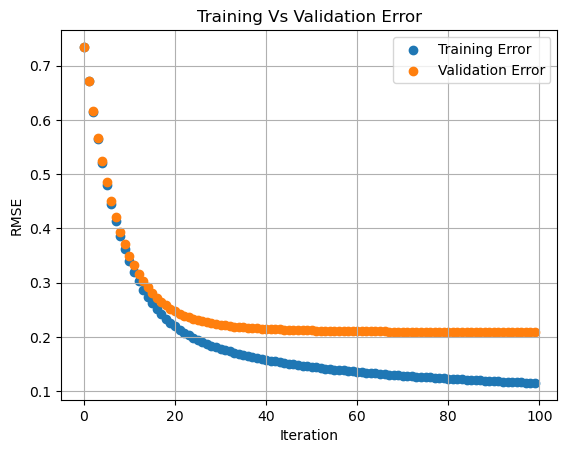

In [9]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

### Evaluate Feature Importances

In [20]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

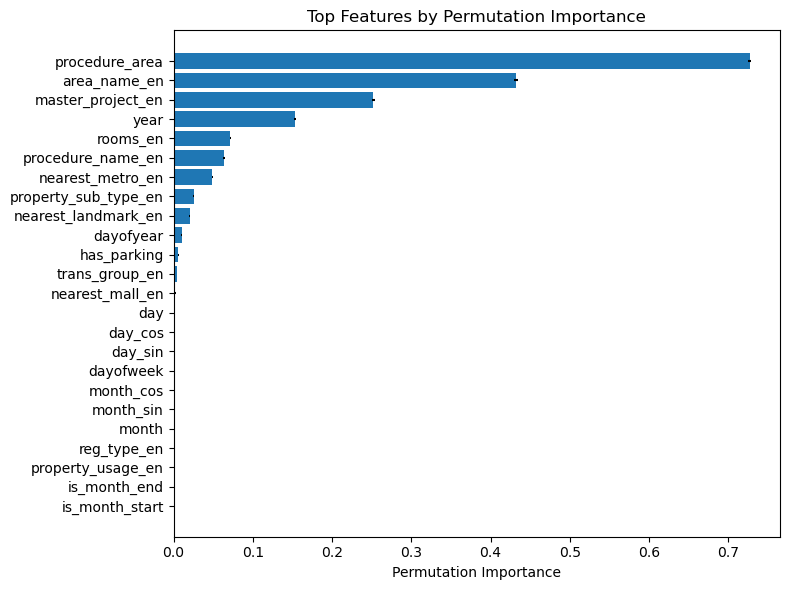

In [28]:
importances = result['importances_mean']
std = result['importances_std']
feature_names = X_test.columns

sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[sorted_idx], xerr=std[sorted_idx], align='center')
plt.yticks(range(len(importances)), feature_names[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.title("Top Features by Permutation Importance")
plt.tight_layout()
plt.show()


**Observation**:
- `procedure_area`, `area_name_en`, and `master_project_en` are the top 3 most impactful features for predicting property worth.

- `year`, `rooms_en`, and `nearest_metro_en` also contribute meaningfully.

- Features like `day`, `month`, and `property_usage_en` have minimal importance, suggesting they can be dropped without harming model performance.

- This plot justifies selecting the top 13 features for a simplified and efficient model.



### Keeping only top 13 features for futher model training

In [ ]:
# Define your top 13 features based on permutation importance
top_13_features = [
    'procedure_area',
    'area_name_en',
    'master_project_en',
    'year',
    'rooms_en',
    'procedure_name_en',
    'nearest_metro_en',
    'property_sub_type_en',
    'nearest_landmark_en',
    'dayofyear',
    'has_parking',
    'trans_group_en',
    'nearest_mall_en'
]

# Prepare feature matrix with ONLY top 13 features
X = df_final[top_13_features].copy()

# Log-transform procedure_area
X['procedure_area'] = np.log1p(X['procedure_area'])

In [ ]:
# Transform data of object type to categories for XGBoost Regressor
categorical_cols = X.select_dtypes(include=['object']).columns
X[categorical_cols]=X[categorical_cols].astype("category")
X.info()

## Hyperparameter tuning

We will start with RandomizedSearchCV and then refine with GridSearchCV.


1. Start with RandomizedSearchCV:

    - We will use broad parameter distributions (like stats.uniform, stats.randint) to explore the hyperparameter space efficiently.

    - This helps identify the general region where good parameters lie, especially for expensive models like XGBoost.

2. Refine with GridSearchCV:

    - After analyzing RandomizedSearchCV results, we will pick narrowed-down parameter ranges.

    - Apply GridSearchCV over specific values (around the best from RandomizedSearch) to fine-tune and possibly improve performance.

### Hyperparameter tuning with **RandomizedSearchCV**

In [43]:
# Split the data into training, testing and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'max_depth': stats.randint(15, 25),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200),
    'reg_alpha': [0, 1, 5],
    'reg_lambda': np.logspace(0, 2, 5)  # [1, 3.16, 10, 31.6, 100]
    }

# Create the XGBoost model object with default parameters
xgb_model = XGBRegressor(
    colsample_bytree=0.5, 
    early_stopping_rounds=5, 
    enable_categorical=True,
    eval_metric='rmse',
    )

# Create the RandomizedSearchCV object
randomized_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    verbose = 2,
    n_jobs = -1,
    n_iter=20,
)

# Fit the RandomizedSearchCV object to the training data
randomized_search.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], verbose=2)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[0]	validation_0-rmse:0.76646	validation_1-rmse:0.76627
[0]	validation_0-rmse:0.78410	validation_1-rmse:0.78395
[0]	validation_0-rmse:0.79334	validation_1-rmse:0.79321
[0]	validation_0-rmse:0.76652	validation_1-rmse:0.76637
[0]	validation_0-rmse:0.78409	validation_1-rmse:0.78396
[0]	validation_0-rmse:0.78408	validation_1-rmse:0.78395
[0]	validation_0-rmse:0.76647	validation_1-rmse:0.76633
[0]	validation_0-rmse:0.79334	validation_1-rmse:0.79322
[0]	validation_0-rmse:0.79335	validation_1-rmse:0.79323
[0]	validation_0-rmse:0.76400	validation_1-rmse:0.76389
[0]	validation_0-rmse:0.76403	validation_1-rmse:0.76391
[0]	validation_0-rmse:0.76399	validation_1-rmse:0.76386
[0]	validation_0-rmse:0.75651	validation_1-rmse:0.75726
[0]	validation_0-rmse:0.77198	validation_1-rmse:0.77255
[0]	validation_0-rmse:0.77195	validation_1-rmse:0.77255
[0]	validation_0-rmse:0.77192	validation_1-rmse:0.77247
[2]	validation_0-rmse:0.69262	validation_1-

/Users/Svetlana/miniconda3/envs/pydata-ml/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[78]	validation_0-rmse:0.15191	validation_1-rmse:0.22391
[44]	validation_0-rmse:0.23641	validation_1-rmse:0.24502
[30]	validation_0-rmse:0.27507	validation_1-rmse:0.27973
[86]	validation_0-rmse:0.21500	validation_1-rmse:0.22818
[46]	validation_0-rmse:0.24978	validation_1-rmse:0.25493
[8]	validation_0-rmse:0.49425	validation_1-rmse:0.49537
[32]	validation_0-rmse:0.26901	validation_1-rmse:0.27266
[76]	validation_0-rmse:0.15963	validation_1-rmse:0.22805
[32]	validation_0-rmse:0.26854	validation_1-rmse:0.27217
[76]	validation_0-rmse:0.16001	validation_1-rmse:0.22708
[46]	validation_0-rmse:0.23556	validation_1-rmse:0.24396
[46]	validation_0-rmse:0.23530	validation_1-rmse:0.24416
[76]	validation_0-rmse:0.15823	validation_1-rmse:0.22832
[32]	validation_0-rmse:0.26727	validation_1-rmse:0.27245
[88]	validation_0-rmse:0.21439	validation_1-rmse:0.22778
[48]	validation_0-rmse:0.24885	validation_1-rmse:0.25410
[10]	validation_0-rmse:0.44961	validation_1-rmse:0.45104
[42]	validation_0-rmse:0.17788	v

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.5, device=None,
                                          early_stopping_rounds=5,
                                          enable_categorical=True,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=Non...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12d7bd3a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12f75bbc0>,
                                        'reg_alpha': [0, 1, 5],
                                        'reg_lambda': array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ]),
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x12d78bb60>},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [44]:
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", randomized_search.best_params_)
print("Best score: ", randomized_search.best_score_)

# Best set of hyperparameters:  {'learning_rate': 0.0701354204238183, 'max_depth': 16, 'n_estimators': 143, 'subsample': 0.9060458311196495}
# Best score:  -392647.60055029264


Best set of hyperparameters:  {'learning_rate': 0.10828460609077827, 'max_depth': 20, 'n_estimators': 190, 'reg_alpha': 0, 'reg_lambda': 31.622776601683793, 'subsample': 0.7784156174183599}
Best score:  -0.21538513439347481


### Hyperparameter tuning with **GridSearchCV**

We will try a small grid centered around the best values from RandomizedSearchCV:
```
{
    'learning_rate': 0.108,
    'max_depth': 20,
    'n_estimators': 190,
    'reg_alpha': 0,
    'reg_lambda': 31.62,
    'subsample': 0.778
}
```

In [18]:
# Define the hyperparameter grid
# Total model combinations = 3×3×3×2×3×2 = 108
# kfold = 3
# Total interations = 108*3 = 324
param_grid = {
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [18, 20, 22],
    'n_estimators': [170, 190, 210],
    'reg_alpha': [0, 1],
    'reg_lambda': [10, 30, 50],
    'subsample': [0.75, 0.8]
}

# Create the XGBoost model object with default parameters
xgb_model = XGBRegressor(
    eval_metric='rmse',
    early_stopping_rounds=5, 
    enable_categorical=True,
    verbosity = 2,
)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    verbose=2
)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)]) 

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[0]	validation_0-rmse:0.73199	validation_1-rmse:0.73308
[1]	validation_0-rmse:0.66666	validation_1-rmse:0.66944
[2]	validation_0-rmse:0.60813	validation_1-rmse:0.61270
[3]	validation_0-rmse:0.55577	validation_1-rmse:0.56225
[4]	validation_0-rmse:0.50889	validation_1-rmse:0.51743
[5]	validation_0-rmse:0.46718	validation_1-rmse:0.47777
[6]	validation_0-rmse:0.42995	validation_1-rmse:0.44286
[7]	validation_0-rmse:0.39675	validation_1-rmse:0.41222
[8]	validation_0-rmse:0.36726	validation_1-rmse:0.38525
[9]	validation_0-rmse:0.34102	validation_1-rmse:0.36183
[10]	validation_0-rmse:0.31779	validation_1-rmse:0.34139
[11]	validation_0-rmse:0.29722	validation_1-rmse:0.32370
[12]	validation_0-rmse:0.27908	validation_1-rmse:0.30841
[13]	validation_0-rmse:0.26313	validation_1-rmse:0.29538
[14]	validation_0-rmse:0.24905	validation_1-rmse:0.28422
[15]	validation_0-rmse:0.23665	validation_1-rmse:0.27469
[16]	validation_0-rmse:0.22583	valida

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=5,
                                    enable_categorical=True, eval_metric='rmse',
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=20, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'reg_alpha': [0, 1, 5],
                         'reg_lambda': array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [31]:
# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 20, 'subsample': 0.7}
Best score:  -0.21846553756758427


## Train Final Model with Tuned Hyperparameters

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 50% for testing and 50% for validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) 

# Define XGBoost Regressor model
model = XGBRegressor(
    enable_categorical=True,
    objective='reg:squarederror', 
    learning_rate=0.07015022673449944, 
    max_depth=23, 
    subsample=0.9159336841414611, 
    n_estimators=142,
    reg_alpha= 1, 
    reg_lambda= 1.0,
    )

# Fit the pipeline on the training data
model.fit(X_train, y_train)

# Evaluate the model
score = model.score(X_test, y_test)
print("Model Score:", score)

Model Score: 0.9295340198802111


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

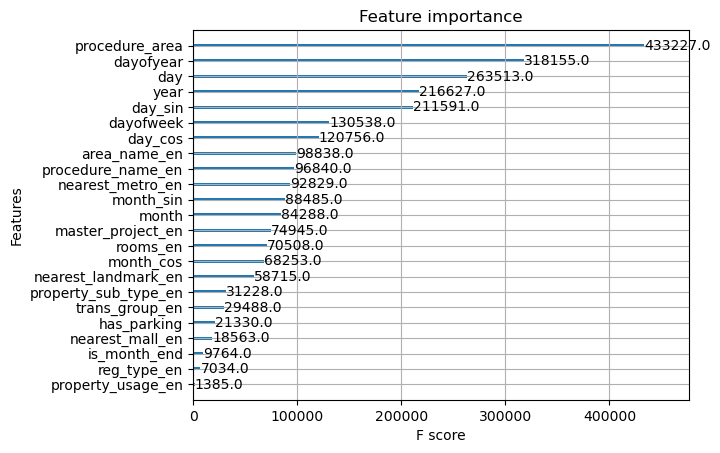

In [14]:
plot_importance(model)

### Make predictions and evaluate the model

In [15]:
y_predict = model.predict(X_test)

In [16]:
df = pd.DataFrame({'y_test': y_test.reset_index(drop=True), 'y_pred': y_predict.round(2)})
print(df.head())

      y_test  y_pred
0  13.071072   13.04
1  14.269766   14.27
2  14.049704   14.13
3  14.881789   14.91
4  14.852248   14.88


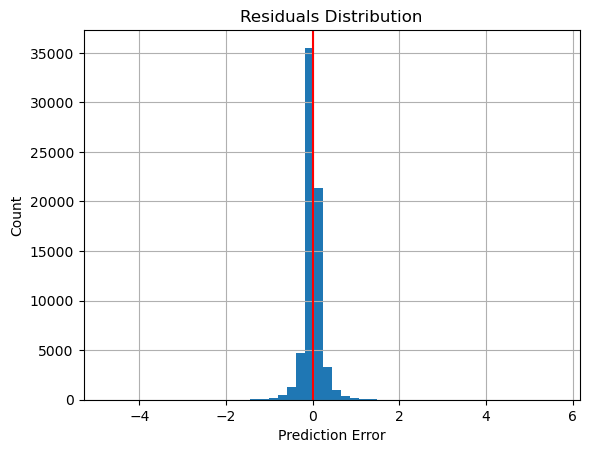

In [25]:
# Test Data Residuals
residuals = (df['y_test'] - df['y_pred'])

plt.hist(residuals,bins=50)
plt.grid(True)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='r')
plt.show()

**Observation:**

The residuals are centered, symmetric, and not heavily skewed.
This is a strong diagnostic indicating that your model generalizes well on the test data.

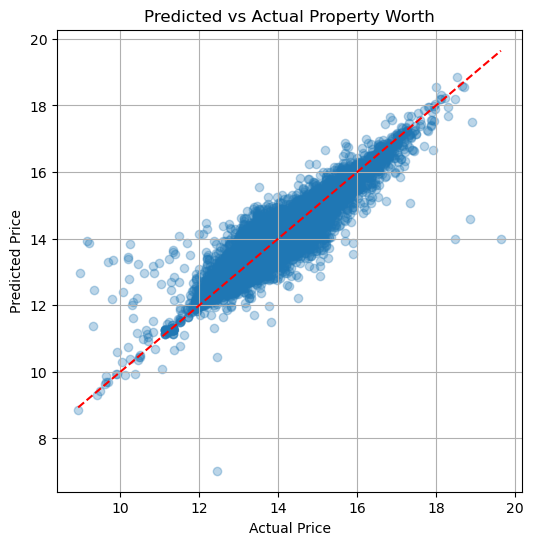

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(df['y_test'], df['y_pred'], alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Property Worth")
plt.grid(True)
plt.show()

In [18]:
value_counts = (residuals > 0).value_counts(sort=False)
print(' Under Estimation: {0:.2f}'.format(value_counts[True]/len(residuals)))
print(' Over  Estimation: {0:.2f}'.format(value_counts[False]/len(residuals)))

 Under Estimation: 0.50
 Over  Estimation: 0.50


**Observation:**

Tight diagonal cluster:
- The points are densely packed around the red line (y = x), which means:

- Most predictions are very close to the actual values.

- The model captures the core pricing patterns effectively.

Slight dispersion at the extremes:
- For very high-priced properties (right side), predictions tend to be underestimated (points fall below the red line).

- For some lower-priced properties, there's slight overprediction.

- This is common in real estate models due to nonlinear price drivers (e.g., luxury effects, rare features, or poor representation of outliers in training data).

Minimal outliers:
- A few scattered points far from the line (e.g., top-left or bottom-right) indicate hard-to-predict properties, but they’re rare.

In [19]:
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
# coefficient of determination - how much variance can be explained by the given features
r2 = r2_score(y_test, y_predict)
# adjusted R-squared - adjusts for the degrees of freedom, effectively penalizing the addition of more predictors to a model
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 0.214 
MSE = 0.04575959826521708 
MAE = 0.12279796162262105 
R2 = 0.9295340198802111 
Adjusted R2 = 0.9295094025855943
